# Generate artificial faces with GANs

In this difficult but very guided exercise, you will learn to train a generative adversarial network in order to generate faces. You will come to realize that the more complex the base distribution you are trying to simulate the more difficult it will become to train the model.

## Load data

1. Import tensorflow

In [ ]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import DataLoader
from torchinfo import summary
from IPython import display
import os
import requests
import zipfile
from pathlib import Path


device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


Let’s define some inputs for the run:

* workers - the number of worker threads for loading the data with the DataLoader.

* batch_size - the batch size used in training. The DCGAN paper uses a batch size of 128.

* image_size - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. 

In [2]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

Define the following variable:

* dataroot - the path to the root of the dataset folder. We will talk more about the dataset in the next section.
* output_path - the name of the file you'll download
* extract_dir - the directory were extracted files will be saved

Then download and extract the files from the given url.

In [28]:
# Root directory for dataset
dataroot = "./img_align_celeba"

# Path to your .tgz file
output_path = "img_align_celeba.zip"
extract_dir = "img_align_celeba"  # Folder where files will be extracted

# Download and extract the dataset
url = 'https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/img_align_celeba.zip'
def load_and_extract_files(url,output_path,extract_dir):
    # Download the dataset
    if not os.path.exists(output_path):
        response = requests.get(url, stream=True)
        with open(output_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print("Download complete.")

    # Extract the dataset
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(output_path, "r") as zip_ref:
            zip_ref.extractall(f"./{extract_dir}")
        print("Extraction complete.")

load_and_extract_files(url,output_path,extract_dir)

## The Celeba dataset


CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including

    10,177 number of identities,

    202,599 number of face images, and

    5 landmark locations, 40 binary attributes annotations per image.

The dataset can be employed as the training and test sets for the following computer vision tasks: face attribute recognition, face recognition, face detection, landmark (or facial part) localization, and face editing & synthesis.

## Data Preprocessing

1. Create an instance of `ImageDataGenerator` with no transformation other than a rescaling. (Make sure you rescale the images so that the values of the pixel range from 0 to 1)
2. Set a variable named `BATCH_SIZE` to 64 and create an `img_generator_flow` object using the `.flow_from_directory` method. The traget size we are working with here is 64 by 64.

In [1]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

NameError: name 'transforms' is not defined

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transform)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


3. Now that we are ready to generate images, display one batch of images from the flow.

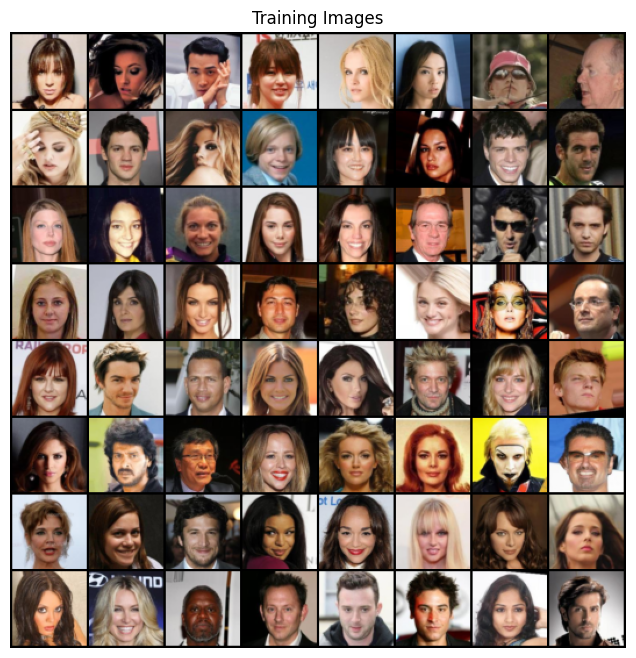

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Building the models

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [ ]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator Model

1. Now it is time to create the generator model which will take some noise vector and transform it into an output the same size as our pictures.

In [8]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

2. Create a sequential model called generator with the following architecture:

<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/dcgan_generator.png" />

For this model we got our inspiration from the following [paper](https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/GAN.pdf) which suggests that:

All Conv Transpose layers use `padding="same"`, `kernel_size=5`, `strides=2` and `activation="relu"`, except for the last layer which needs to have a `"sigmoid"` activation (because the generator model needs to produce pixels with values between 0 and 1).

It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. 

<Note type="tip" title="Architecture">
In case you are unsure of the architecture you should build for this model take a look the output below which will give you an idea of the layers used.
</Note>

In [ ]:
# Generator Code
class Generator(nn.Module):

    def __init__(self, ngpu):
        super(Generator, self).__init__()

        self.ngpu = ngpu
        
        self.main = nn.Sequential(

            # input is Z, going into a convolution

            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf*8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``

            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``

            nn.ConvTranspose2d( in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``

            nn.ConvTranspose2d( in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``

            nn.ConvTranspose2d( in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

3. Display the architecture of the model using the summary command.

In [ ]:
# Instantiate Generator
netG = Generator(ngpu=ngpu)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print model summary
summary(netG, input_size=(1, nz, 1,1))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─ConvTranspose2d: 2-1              [1, 512, 4, 4]            819,200
│    └─BatchNorm2d: 2-2                  [1, 512, 4, 4]            1,024
│    └─ReLU: 2-3                         [1, 512, 4, 4]            --
│    └─ConvTranspose2d: 2-4              [1, 256, 8, 8]            2,097,152
│    └─BatchNorm2d: 2-5                  [1, 256, 8, 8]            512
│    └─ReLU: 2-6                         [1, 256, 8, 8]            --
│    └─ConvTranspose2d: 2-7              [1, 128, 16, 16]          524,288
│    └─BatchNorm2d: 2-8                  [1, 128, 16, 16]          256
│    └─ReLU: 2-9                         [1, 128, 16, 16]          --
│    └─ConvTranspose2d: 2-10             [1, 64, 32, 32]           131,072
│    └─BatchNorm2d: 2-11                 [1, 64, 32, 32]  

4. Create a random noise vector and feed it to the generator model in order to try it out. (Use `torch.randn` to generate the data)

torch.Size([1, 3, 64, 64])


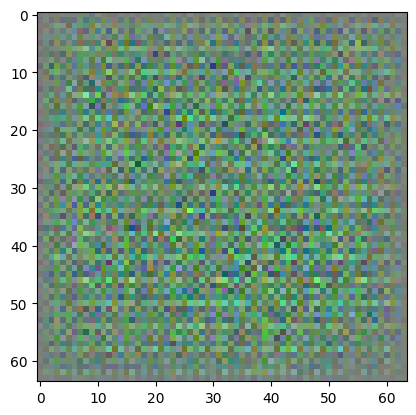

In [11]:
# 🔥 Example Usage
# Generate random latent input (batch_size, 100)
random_input = torch.randn(1, nz, 1,1,device=device)

### Model application
netG.eval() # prevent model from training
netG.to(device)
fake_images = netG(random_input)

### Model visualisation
plt.imshow(np.transpose(vutils.make_grid(fake_images[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

# Output shape
print(fake_images.shape)  # Expected: torch.Size([16, 1, 28, 28])


## Discriminator Model

1. Create a sequential model called `discriminator` with the following architecture:
* Alternate convolutional layers and batchnormalization except for first and last layer.
* All layers use, `kernel_size=4`, and `nn.ReLU` activations, except for the last layer which uses `nn.Sigmoid` because the target variable is binary (the image is fake or real).

<Note type="tip" title="Architecture">
In case you are unsure of the architecture you should build for this model take a look the output below which will give you an idea of the layers used.
</Note>

In [ ]:
# Discriminator Code
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()

        self.ngpu = ngpu
        
        self.main = nn.Sequential(
            
            # input is ``(nc) x 64 x 64``

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size. ``(ndf) x 32 x 32``
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.ReLU(inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.ReLU(inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.ReLU(inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Instantiate Generator
netD = Discriminator(ngpu)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netD.apply(weights_init)

# Print model summary
summary(netD, input_size=(1, 3, 64, 64))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1, 1, 1]              --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           3,072
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 128, 16, 16]          131,072
│    └─BatchNorm2d: 2-4                  [1, 128, 16, 16]          256
│    └─ReLU: 2-5                         [1, 128, 16, 16]          --
│    └─Conv2d: 2-6                       [1, 256, 8, 8]            524,288
│    └─BatchNorm2d: 2-7                  [1, 256, 8, 8]            512
│    └─ReLU: 2-8                         [1, 256, 8, 8]            --
│    └─Conv2d: 2-9                       [1, 512, 4, 4]            2,097,152
│    └─BatchNorm2d: 2-10                 [1, 512, 4, 4]            1,024
│    └─ReLU: 2-11                        [1, 512, 4, 4]     

## Preparing for training
1. In order to train our models, we are going to use the `BinaryCrossentropy` s a base to create custom loss functions, start by creating an instance of this loss function.

In [14]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

2. Define a function called `discriminator_loss` it will serve as theloss for the (you guessed it...) Discriminator model!


In [15]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training Step

In this question we will guide you step by step to create your training step function, it is directly inspired from the demo on the MNIST dataset so do not hesitate to find help there as well!

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake. In terms of Goodfellow, we wish to “update the discriminator by ascending its stochastic gradient”. Practically, we want to maximize log(D(x))+log(1−D(G(z)))log(D(x)) + log(1-D(G(z)))log(D(x))+log(1−D(G(z))). Due to the separate mini-batch suggestion from [ganhacks](https://github.com/soumith/ganhacks), we will calculate this in two steps. First, we will construct a batch of real samples from the training set, forward pass through DDD, calculate the loss (log(D(x))log(D(x))log(D(x))), then calculate the gradients in a backward pass. Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through DDD, calculate the loss (log(1−D(G(z)))log(1-D(G(z)))log(1−D(G(z)))), and _accumulate_ the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer.

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by minimizing log(1−D(G(z)))log(1-D(G(z)))log(1−D(G(z))) in an effort to generate better fakes. As mentioned, this was shown by Goodfellow to not provide sufficient gradients, especially early in the learning process. As a fix, we instead wish to maximize log(D(G(z)))log(D(G(z)))log(D(G(z))). In the code we accomplish this by: classifying the Generator output from Part 1 with the Discriminator, computing G’s loss _using real labels as GT_, computing G’s gradients in a backward pass, and finally updating G’s parameters with an optimizer step. It may seem counter-intuitive to use the real labels as GT labels for the loss function, but this allows us to use the log(x)log(x)log(x) part of the `BCELoss` (rather than the log(1−x)log(1-x)log(1−x) part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each epoch we will push our fixed\_noise batch through the generator to visually track the progress of G’s training. The training statistics reported are:

-   **Loss\_D** - discriminator loss calculated as the sum of losses for the all real and all fake batches (log(D(x))+log(1−D(G(z)))log(D(x)) + log(1 - D(G(z)))log(D(x))+log(1−D(G(z)))).
    
-   **Loss\_G** - generator loss calculated as log(D(G(z)))log(D(G(z)))log(D(G(z)))
    
-   **D(x)** - the average output (across the batch) of the discriminator for the all real batch. This should start close to 1 then theoretically converge to 0.5 when G gets better. Think about why this is.
    
-   **D(G(z))** - average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated. These numbers should start near 0 and converge to 0.5 as G gets better. Think about why this is.
    

**Note:** This step might take a while, depending on how many epochs you run and if you removed some data from the dataset.

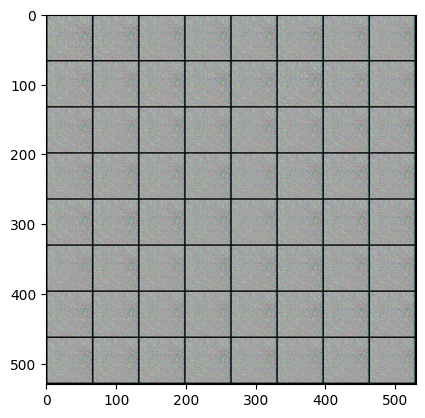

[0/5][650/1583]	Loss_D: 0.0004	Loss_G: 8.7964	D(x): 0.9998	D(G(z)): 0.0003 / 0.0002


KeyboardInterrupt: 

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# send both models to device
netG.to(device)
netD.to(device)

print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):

    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Generate a new batch of latent vectors so both models do not train on similar examples
        # which could lead to overfitting
        noise2 = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake2 = netG(noise2)

        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake2).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            
            # Clear the output to leave room for next set of images
            display.clear_output(wait=True)
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()

            # Display the next set of images using the fixed noise
            plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
            plt.show()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

## Results

Finally, lets check out how we did. Here, we will look at three different results. First, we will see how D and G’s losses changed during training.

1. Plot the evolution of the discriminator loss against the generator loss.

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=G_losses,
                          name="Generator Loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=D_losses,
                          name="Discriminator Loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])

fig.update_layout(
    title='Training of the GAN',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)

fig.show()

2. Visualization of G’s progression

Remember how we saved the generator’s output on the fixed_noise batch after every epoch of training. Now, we can visualize the training progression of G with an animation. Press the play button to start the animation.

Use the display function from the demo to show the generator's evolution through training.

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Here is what you can hope to see after 1000 epochs (or 5000 steps):

<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/images/M08-DeepLearning/gans/generated_99.png" />

GANs are hard to train and are very ressource-intensive models to train, and the difficulty increases exponentially with the dimension of the distribution you are trying to model (for instance training a model that could generate super realistic images in HD took 3 months for Google to train!)

## To go a little further

In order to achieve better results, and mostly better generalization performance for the generator it is possible to use some sort of regularization, to find out how, read on...

The goal of the discriminator is to predict `1` for real images and `0` for fake images, so we may be simply want to compute the binary cross entropy between `real_ouput` and `1`, and `fake_output` and `0`, but GANs are very sensitive models, and specifically we do not want the discriminator to get too good too quickly otherwise the generator will not be able to improve, so we will add some noise to the expected labels for the real and fake images (the idea is that we want the discriminator to think the real images are real but not 100% real, and the fake images not 100% fake, this small confusion will create some weakness that the generator will be able to exploit).